# Time Series

## Baselines models

In [ ]:
#import requests
# get time series from internet
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
#response = requests.get(url)
# save time series to file
#with open('../input/time_series_covid19_confirmed_global.csv', 'w') as f:
#    f.write(response.text)

In [45]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.metrics import mape
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

,USA,Spain
2020-01-22,0,1
2020-01-23,0,1
2020-01-24,0,2
2020-01-25,0,2
2020-01-26,0,5
...,...,...
2021-11-16,5061045,47310337
2021-11-17,5067712,47421741
2021-11-18,5074027,47531319
2021-11-19,5080663,47660379


<AxesSubplot:>

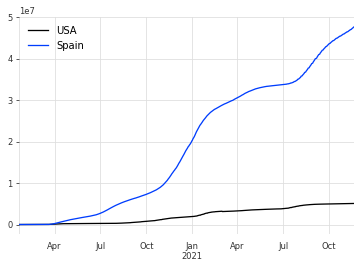

In [2]:
# read time series from file
df = pd.read_csv('../input/time_series_covid19_confirmed_global.csv')
# select countries from a list
df_ = df[df['Country/Region'].isin(['US','Spain'])]
# drop 3 first rows
df_ = df_.T.iloc[4:]
# rename columns
df_.rename(columns={237:'USA', 255:'Spain'}, inplace=True)
# convert index to datetime
df_.index = pd.to_datetime(df_.index)
# visualization
display(df_)
df_.plot()

In [6]:
# select Spain
df_spain = df_['Spain']

In [7]:
# create DART time series from dataframe
ts = TimeSeries.from_series(df_spain)
ts


<TimeSeries (DataArray) (time: 669, component: 1, sample: 1)>
array([[[1.0000000e+00]],

       [[1.0000000e+00]],

       [[2.0000000e+00]],

       [[2.0000000e+00]],

       [[5.0000000e+00]],

       [[5.0000000e+00]],

       [[5.0000000e+00]],

       [[6.0000000e+00]],

       [[6.0000000e+00]],

       [[8.0000000e+00]],

...

       [[4.6866719e+07]],

       [[4.7012970e+07]],

       [[4.7053803e+07]],

       [[4.7083964e+07]],

       [[4.7222751e+07]],

       [[4.7310337e+07]],

       [[4.7421741e+07]],

       [[4.7531319e+07]],

       [[4.7660379e+07]],

       [[4.7701872e+07]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2021-11-20
  * component  (component) object 'Spain'
Dimensions without coordinates: sample

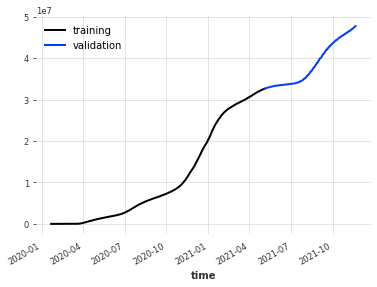

In [47]:
train, val = ts[:-200], ts[-200:]
train.plot(label='training')
val.plot(label='validation')
plt.legend();

model Exponential smoothing obtains MAPE: 4.99%
model Prophet obtains MAPE: 4.74%
model Auto-ARIMA obtains MAPE: 5.50%
model Theta(2) obtains MAPE: 6.07%


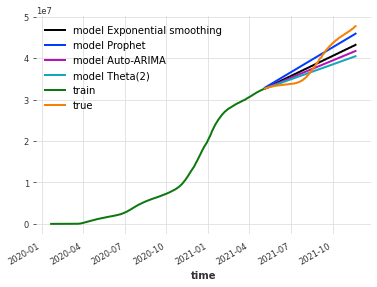

In [52]:
# train models
def eval_model(model):
    global forecast
    model.fit(train)
    forecast = model.predict(len(val))
    print(f'model {model} obtains MAPE: {mape(val,forecast):.2f}%')
    forecast.plot(label=f'model {model}')
    plt.legend()

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

train.plot(label='train')
val.plot(label='true')
plt.legend()


The MAPE is: 4.50, with theta = 7.1020408163265305.


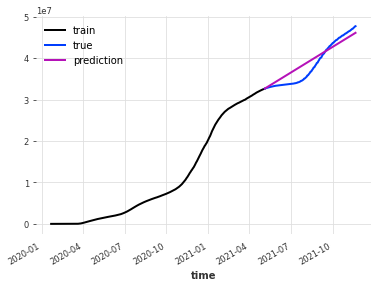

In [53]:
## Tuning the theta parameter to see if MAPE reduces
## Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta
        
## Fitting and predicting again usinh best theta value
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

## Visualize 
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend()